<a href="https://colab.research.google.com/github/cocoisland/DS-Unit-2-Sprint-4-Model-Validation/blob/master/DS_Unit_2_Sprint_Challenge_4_Model_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [0]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [41]:
df.columns

Index(['months_since_last_donation', 'number_of_donations',
       'total_volume_donated', 'months_since_first_donation',
       'made_donation_in_march_2007'],
      dtype='object')

In [42]:
# numpy method
import numpy as np
majority_class = df['made_donation_in_march_2007'].mode()[0]
y_pred = np.full(shape=df['made_donation_in_march_2007'].shape, fill_value=majority_class)
df['made_donation_in_march_2007'].shape, y_pred.shape

((748,), (748,))

In [43]:
# majority class baseline
from sklearn.metrics import accuracy_score
accuracy_score(df['made_donation_in_march_2007'], y_pred)

0.7620320855614974

In [44]:
# pandas function method
df.made_donation_in_march_2007.value_counts(normalize=True)

0    0.762032
1    0.237968
Name: made_donation_in_march_2007, dtype: float64

In [45]:
# pandas method 2
1 - df.made_donation_in_march_2007.mean()

0.7620320855614973

What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

###Recall for majority class baseline :  Zero relevant(donor who return) are selected.

###Recall = 0/(0+0) = 0

###Zero is the majority class label. Majority (76%) donors did not return.


In [46]:
from sklearn.metrics import classification_report
print(classification_report(df['made_donation_in_march_2007'], y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       570
           1       0.00      0.00      0.00       178

   micro avg       0.76      0.76      0.76       748
   macro avg       0.38      0.50      0.43       748
weighted avg       0.58      0.76      0.66       748



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [0]:
# Small dataset - two ways split
from sklearn.model_selection import train_test_split

X=df.drop('made_donation_in_march_2007', axis=1)
y=df['made_donation_in_march_2007']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, shuffle=True)



In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LogisticRegression(solver='lbfgs'), X_train, y_train, 
                        scoring='accuracy', cv=3, 
                        return_train_score=True, return_estimator=True)

pd.DataFrame(scores)

,estimator,fit_time,score_time,test_score,train_score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.010339,0.000881,0.776596,0.809651
1,"LogisticRegression(C=1.0, class_weight=None, d...",0.011038,0.000858,0.780749,0.775401
2,"LogisticRegression(C=1.0, class_weight=None, d...",0.010003,0.000772,0.795699,0.776000


## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest

pipe = make_pipeline(
    StandardScaler(), 
    SelectKBest(f_classif), 
    LogisticRegression())


## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [49]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
#df=df.astype('float64')

param_grid = {
    'selectkbest__k': [1,2,3,4],
    'logisticregression__class_weight': [None,'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
    
}

recall_scorer = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)

gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, 
                  #scoring= 'recall',
                  scoring=recall_scorer,
                  return_train_score=True,
                  verbose=0)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f239d0f6840>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': [1, 2, 3, 4], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(recall_score), verbose=0)

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [50]:
validation_score = gs.best_score_
print()
print(' Best validation Recall Score:', validation_score)
print()
print('Best paramter:', gs.best_params_)
print()
print('Best estimator:', gs.best_estimator_)
print()


 Best validation Recall Score: 0.8152337858220211

Best paramter: {'logisticregression__C': 0.0001, 'logisticregression__class_weight': 'balanced', 'selectkbest__k': 2}

Best estimator: Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=2, score_func=<function f_classif at 0x7f239d0f6840>)), ('logisticregression', LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])



In [51]:
results = pd.DataFrame(gs.cv_results_)
print(f'Best result from grid search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head()

Best result from grid search of 72 parameter combinations


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_logisticregression__C,param_logisticregression__class_weight,param_selectkbest__k,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
13,0.003388,0.001312,0.815234,0.817308,0.001,balanced,2,"{'logisticregression__C': 0.001, 'logisticregr...",1,0.730769,...,0.884615,0.798077,0.884615,0.798077,0.884615,0.807692,0.000035,0.000016,0.085656,0.020169
5,0.003356,0.001336,0.815234,0.821154,0.0001,balanced,2,"{'logisticregression__C': 0.0001, 'logisticreg...",1,0.730769,...,0.884615,0.798077,0.884615,0.807692,0.884615,0.817308,0.000133,0.000014,0.085656,0.017834
21,0.003345,0.001314,0.799877,0.798077,0.01,balanced,2,"{'logisticregression__C': 0.01, 'logisticregre...",3,0.730769,...,0.884615,0.778846,0.846154,0.788462,0.846154,0.788462,0.000044,0.000009,0.074570,0.017201
12,0.003483,0.001242,0.799877,0.800000,0.001,balanced,1,"{'logisticregression__C': 0.001, 'logisticregr...",3,0.730769,...,0.923077,0.769231,0.884615,0.778846,0.807692,0.798077,0.000289,0.000018,0.098465,0.024627
4,0.003252,0.001266,0.799877,0.800000,0.0001,balanced,1,"{'logisticregression__C': 0.0001, 'logisticreg...",3,0.730769,...,0.923077,0.769231,0.884615,0.778846,0.807692,0.798077,0.000016,0.000031,0.098465,0.024627


In [52]:

selector = gs.best_estimator_.named_steps['selectkbest']
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print()
print('Features not selected:')
for name in unselected_names:
    print(name)


Features selected:
months_since_last_donation
number_of_donations

Features not selected:
total_volume_donated
months_since_first_donation


## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

Calculate accuracy

In [0]:
accuracy=(85+36)/(85+58+8+36)

#  true positive / overall positive
precision= 36/(36+58) # num of selected are relevant

# true positive / selected positive
recall=36/(36+8) # num of relevant are selected

# false positive
fpr=58/(58+85)


## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 

In [54]:
# Part 3
from sklearn.metrics import precision_score

y_pred = gs.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred) # selected are relevant
recall=recall_score(y_test, y_pred)       # relevant are selected



print(f'Accuracy={accuracy}, Precision={precision}, Recall={recall}')

Accuracy=0.5989304812834224, Precision=0.37383177570093457, Recall=0.8333333333333334


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.52      0.66       139
           1       0.37      0.83      0.52        48

   micro avg       0.60      0.60      0.60       187
   macro avg       0.64      0.68      0.59       187
weighted avg       0.76      0.60      0.62       187



In [60]:
gs_test_score = gs.score(X_test, y_test)
print('GridSearchCV Test Score:', gs_test_score)

GridSearchCV Test Score: 0.8333333333333334


In [61]:
# Part 4
#The F1 score can be interpreted as a weighted average of the precision and recall.
#F1 score reaches its best value at 1 and worst score at 0. 
#F1 = 2 * (precision * recall) / (precision + recall)
from sklearn.metrics import f1_score

f1_sklearn=f1_score(y_test, y_pred)  
f1_manual=2 * (precision * recall)/(precision + recall)

print(f'F1_sklearn={f1_sklearn}, F1_manual={f1_manual}')

F1_sklearn=0.5161290322580645, F1_manual=0.5161290322580645


In [62]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[72, 67],
       [ 8, 40]])

In [71]:
accuracy=(72+40)/(72+40+8+67)

#  true positive / overall positive
precision= 40/(40+67) # num of selected are relevant

# true positive / selected positive
recall=40/(40+8) # num of relevant are selected

# false positive
fpr=67/(67+72)

print('Manual=Precision={:0.2f}, Recall={:0.2f}, Accuracy={:0.2f}, \
  False positive={:0.2f}'.format(precision,recall,accuracy,fpr))

accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred) # selected are relevant
recall=recall_score(y_test, y_pred)  

print('Sklearn=Precision={:0.2f}, Recall={:0.2f}, Accuracy={:0.2f}, \
  False positive={:0.2f}'.format(precision,recall,accuracy,fpr))


Manual=Precision=0.37, Recall=0.83, Accuracy=0.60,   False positive=0.48
Sklearn=Precision=0.37, Recall=0.83, Accuracy=0.60,   False positive=0.48


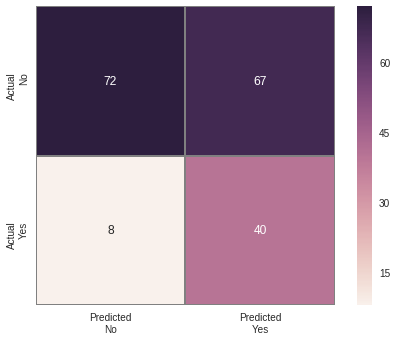

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_viz(y_true, y_pred, normalize=False):
    matrix = confusion_matrix(y_true, y_pred)
    
    if (normalize):
      matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] # normalize
      matrix = np.round(matrix,2)
    
    return sns.heatmap(matrix, annot=True, 
                       fmt=',', linewidths=1, linecolor='grey', 
                       square=True, 
                       xticklabels=['Predicted\nNo', 'Predicted\nYes'], 
                       yticklabels=['Actual\nNo', 'Actual\nYes'])

confusion_viz(y_test, y_pred, normalize=False);

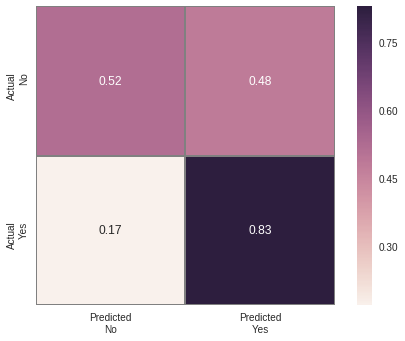

In [73]:
confusion_viz(y_test, y_pred, normalize=True)